In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx = int(4000)
ny = int(2800)

In [3]:
11200000/2800

4000.0

In [4]:
x0 = 90
x1 = 290
y0 = -70
y1 = 70

bathymetry = np.fromfile('../data/bathymetry3min',dtype='float64')[2:]
                                                                              

bathymetry = bathymetry.reshape((ny,-1))

x = np.linspace(x0,x1, bathymetry.shape[1])
y = np.linspace(y0,y1, bathymetry.shape[0])
x, y = np.meshgrid(x, y)

In [5]:
bathymetry.shape

(2800, 4000)

In [6]:
hfirst = np.loadtxt('../tsunamilab/tlab2D',delimiter=',',skiprows=1).reshape((ny,-1))

hmax = np.loadtxt('../tsunamilab/tlab2D (1)',delimiter=',',skiprows=1).reshape((ny,-1))

harr = np.loadtxt('../tsunamilab/tlab2D (2)',delimiter=',',skiprows=1).reshape((ny,-1))

harrmasked = np.ma.masked_where(bathymetry<500,harr)

In [7]:
s = 10

/home/jose/gitrepos/tesis/venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


<a list of 8 text.Text objects>

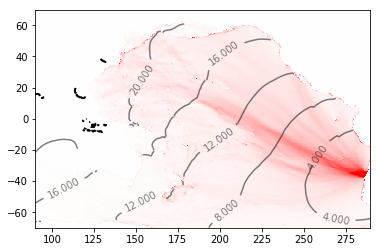

In [8]:
plt.pcolormesh(x[::s,::s],y[::s,::s],hmax[::s,::s],vmax=1,vmin=-1, cmap=plt.cm.bwr)

CS = plt.contour(x[::s,::s],y[::s,::s],harrmasked[::s,::s]/60/60,np.arange(0,24,4),colors='k', linewidth=0.5, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=10)